In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [47]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [48]:
offense['Year'] += 1
defense['Year'] += 1

In [49]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

In [50]:
# split out the X and y from combined
X_all = combined[combined.columns[:-8]].copy()
y_all = combined[combined.columns[-8:]].copy()

# add team and year back into y
y_all.insert(0, 'Team', X_all['Team'])
y_all.insert(1, 'Year', X_all['Year'])

In [56]:
target_var = 'SB_win'

In [57]:
data = X_all.merge(y_all[['Team', 'Year', target_var]])

data_future = data[data['Year'] == 2018]

data = data[data['Year'] < 2018]

features = data.columns[2:-1]

In [58]:
data[target_var].value_counts()

0.0000    155
1.0000      5
Name: SB_win, dtype: int64

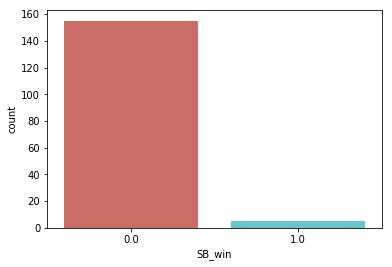

In [60]:
_ = sns.countplot(x=target_var, data=data, palette='hls')

In [62]:
data.groupby(target_var).mean().T

SB_win,0.0,1.0
Year,2015.0000,2015.0000
Yds/G_rush_off,111.2871,120.6000
TD_rush_off,12.3806,16.0000
Yds/G_pass_off,237.4265,249.3800
Pct_off,62.0613,63.3600
TD_pass_off,24.8516,28.8000
Sck_off,37.5484,32.2000
Rate_off,87.7994,94.0600
Pts/G_off,22.7284,27.1400
Pen Yds_off,891.0903,872.8000


## Logistic Regression

#### Start with a baseline model

In [63]:
X = data[features]
y = data[target_var]

In [64]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [65]:
X_valid = X[data['Year'] == 2017]
y_valid = y[data['Year'] == 2017]

X = X.loc[data['Year'] < 2017]
y = y.loc[data['Year'] < 2017]

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logit = LogisticRegression()

logit.fit(X, y)

y_pred = logit.predict(X_valid)
y_proba = logit.predict_proba(X_valid)

print(classification_report(y_valid, y_pred))

print(confusion_matrix(y_valid, y_pred))

             precision    recall  f1-score   support

        0.0       0.96      0.87      0.92        31
        1.0       0.00      0.00      0.00         1

avg / total       0.93      0.84      0.89        32

[[27  4]
 [ 1  0]]


In [74]:
y_proba, data[data['Year'] == 2017]['Team']

(array([[0.34697512, 0.65302488],
        [0.20252433, 0.79747567],
        [0.84883214, 0.15116786],
        [0.98635006, 0.01364994],
        [0.52695525, 0.47304475],
        [0.49060612, 0.50939388],
        [0.48369039, 0.51630961],
        [0.93001284, 0.06998716],
        [0.98543645, 0.01456355],
        [0.79056578, 0.20943422],
        [0.69386081, 0.30613919],
        [0.99764423, 0.00235577],
        [0.81034566, 0.18965434],
        [0.89678478, 0.10321522],
        [0.98098133, 0.01901867],
        [0.94847963, 0.05152037],
        [0.94084618, 0.05915382],
        [0.66886486, 0.33113514],
        [0.99522845, 0.00477155],
        [0.84313466, 0.15686534],
        [0.77555299, 0.22444701],
        [0.93021552, 0.06978448],
        [0.96505531, 0.03494469],
        [0.99077669, 0.00922331],
        [0.97510619, 0.02489381],
        [0.91648874, 0.08351126],
        [0.9071288 , 0.0928712 ],
        [0.98086226, 0.01913774],
        [0.99018627, 0.00981373],
        [0.982

In [67]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X, y)

y_pred = svc.predict(X_valid)

print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98        31
        1.0       0.00      0.00      0.00         1

avg / total       0.94      0.97      0.95        32

[[31  0]
 [ 1  0]]


/Users/tsansom/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X, y)

y_pred = svc.predict(X_valid)

print(classification_report(y_valid, y_pred))
print(confusion_matrix(y_valid, y_pred))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98        31
        1.0       0.00      0.00      0.00         1

avg / total       0.94      0.97      0.95        32

[[31  0]
 [ 1  0]]


/Users/tsansom/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
